### 분류문제
1. 로지스틱회귀 -> 로지스틱의 하이퍼파라미터는 penalty, C
2. 결정트리 -> 그리드서치 사용, 표준화 불필요
3. SVM -> 파이프라인 사용, SVM의 하이퍼파라미터는 감마와 C

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA

In [3]:
df=pd.read_csv("HW4.csv",sep=";")

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
df=df.drop(['day','month'],axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   duration   4521 non-null   int64 
 10  campaign   4521 non-null   int64 
 11  pdays      4521 non-null   int64 
 12  previous   4521 non-null   int64 
 13  poutcome   4521 non-null   object
 14  y          4521 non-null   object
dtypes: int64(6), object(9)
memory usage: 529.9+ KB


In [16]:
cat_feat=[name for name in list(df.columns) if df[name].dtype=='object' and name !='y']
num_feat=[name for name in list(df.columns) if df[name].dtype=='int64' and name !='y']

In [17]:
df.y.value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [18]:
df.shape

(4521, 15)

In [19]:
df.y.value_counts()/df.shape[0]

no     0.88476
yes    0.11524
Name: y, dtype: float64

In [20]:
df[num_feat].describe()

,age,balance,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,3025.000000,50.000000,871.000000,25.000000


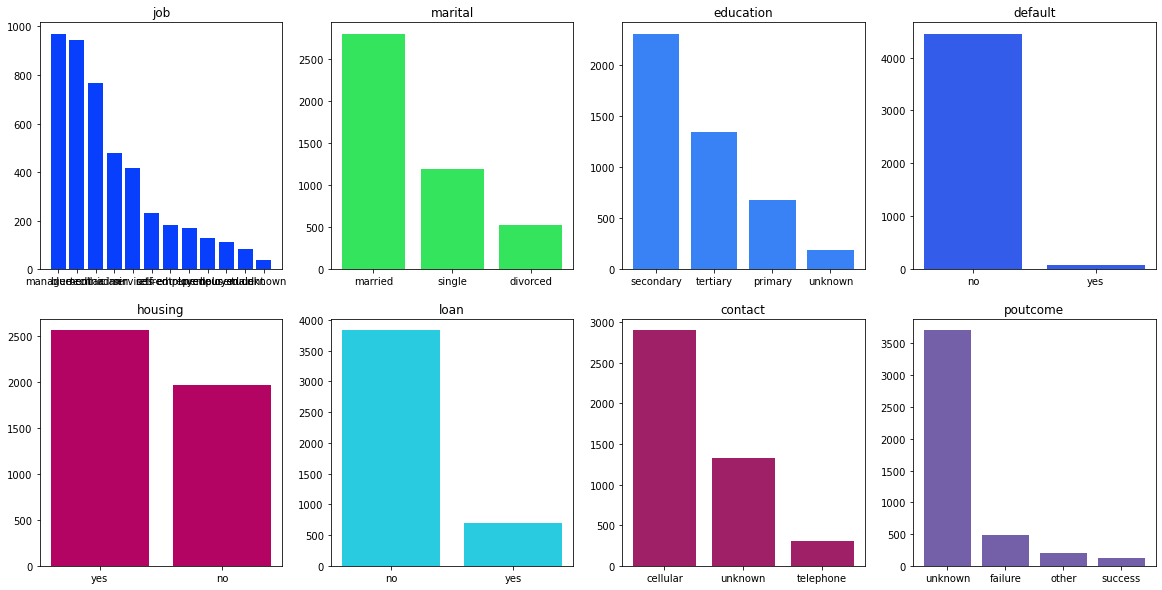

In [22]:
plt.figure(figsize=(20,10))
i=1
for name in cat_feat:
    counts=df[name].value_counts()
    plt.subplot(2,4,i)
    c=(np.random.random(),np.random.random(),np.random.random())
    plt.bar(counts.index,counts.values,color=c)
    plt.title(name)
    i=i+1

In [23]:
features=df.drop('y',axis=1)
label=df['y']

In [25]:
y=np.where(label=='no',1,0)

In [27]:
y[10:50]

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [28]:
feature_dummy=pd.get_dummies(features)

In [29]:
feature_dummy

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,79,1,-1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
1,33,4789,220,1,339,4,0,0,0,0,...,1,0,1,1,0,0,1,0,0,0
2,35,1350,185,1,330,1,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
3,30,1476,199,4,-1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
4,59,0,226,1,-1,0,0,1,0,0,...,1,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,-333,329,5,-1,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,1
4517,57,-3313,153,1,-1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
4518,57,295,151,11,-1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4519,28,1137,129,4,211,3,0,1,0,0,...,0,1,0,1,0,0,0,1,0,0


In [30]:
X=feature_dummy.to_numpy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)

In [33]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train_std=scaler.transform(X_train)
X_test_std=scaler.transform(X_test)

In [35]:
#로지스틱회귀
c_list = [0.01, 0.1, 1, 10, 100]
best_scores=0

for k in c_list:
    scores_logistic=cross_val_score(estimator=LogisticRegression(C=k,random_state=1),
                                   X=X_train_std,y=y_train,cv=5,n_jobs=-1)
    scores=np.mean(scores_logistic)
    
    print('C=',k,'accuracy=',scores)
    
    if scores>best_scores:
        best_scores=scores
        best_param={'C':k}


C= 0.01 accuracy= 0.8990612319754246
C= 0.1 accuracy= 0.9015485660576328
C= 1 accuracy= 0.9009953157118513
C= 10 accuracy= 0.9007186905389606
C= 100 accuracy= 0.9007186905389606


In [36]:
print(best_scores)
print(best_param)
logistic=LogisticRegression(**best_param,random_state=1)
logistic.fit(X_train_std,y_train)
logistic.score(X_test_std,y_test)

0.9015485660576328
{'C': 0.1}


0.8917127071823204

In [37]:
y_pred=logistic.predict(X_test_std)
conf_mat=confusion_matrix(y_test,y_pred)

In [38]:
conf_mat

array([[ 32,  72],
       [ 26, 775]], dtype=int64)

In [40]:
precision_score(y_test,y_pred)

0.9149940968122786

In [42]:
recall_score(y_test,y_pred)

0.9675405742821473

In [43]:
#결정트리
param={'max_depth':range(1,11)}
gscv=GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),param_grid=param,
                 scoring='accuracy',cv=5,n_jobs=-1)
gscv.fit(X_train,y_train)
print(gscv.best_params_)
print(gscv.score(X_test,y_test))

{'max_depth': 6}
0.8983425414364641


In [44]:
#파이프라인 SVC 모델 튜닝
pipe_scv=make_pipeline(StandardScaler(),PCA(n_components=5),SVC(kernel='rbf',random_state=1))
p_list=[0.01,0.1,1,10,100]

param_grid={'svc__C':p_list,"svc__gamma":p_list}
gs=GridSearchCV(estimator=pipe_scv,param_grid=param_grid,scoring='accuracy',cv=5,n_jobs=-1)
gs.fit(X_train,y_train)
print(gs.best_params_)
print(gs.score(X_test,y_test))

{'svc__C': 10, 'svc__gamma': 0.1}
0.8895027624309392
